In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import cv2
from keras.models import load_model,Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras.backend import set_session,clear_session,get_session
import gc
def show_images_labels_predictions(images,labels,predictions,start_id,num=10):
  plt.gcf().set_size_inches(12,14)
  if num>25: num=25
  for i in range(0,num):
    ax=plt.subplot(5,5,1+i) # 畫圖但用子圖呈現
    ax.imshow(images[start_id])
    if(len(predictions)>0):
      title='ai='+str(predictions[start_id])
      title+=('(o)' if predictions[start_id]==labels[start_id] else '(x)')
      title+='\nlabel='+str(labels[start_id])
    else:
      title='label='+str(labels[start_id])
    ax.set_title(title,fontsize=12)
    ax.set_xticks([]);ax.set_yticks([])
    start_id+=1
  plt.show()
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
np.random.seed(1)

<h1>處理資料

In [2]:
cat_files=glob.glob("./train/cat/*.jpg")
dog_files=glob.glob("./train/dog/*.jpg")
wildlife_files=glob.glob("./train/wild/*.jpg")

In [3]:
print(len(cat_files),len(dog_files),len(wildlife_files))

5153 4739 4738


In [4]:
cat=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in cat_files[:4500]]
dog=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in dog_files[:4500]]
wildlife=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in wildlife_files[:4500]]
#,cv2.IMREAD_GRAYSCALE

In [5]:
cat=np.array(cat)
dog=np.array(dog)
wildlife=np.array(wildlife)
print(cat.shape,dog.shape,wildlife.shape)

(4500, 256, 256) (4500, 256, 256) (4500, 256, 256)


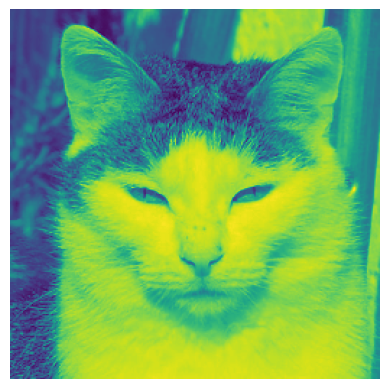

In [6]:
plt.imshow(cat[100])
plt.axis('off')
plt.show()

In [7]:
label=[]
# 貓的標籤為0
for i in cat:
    label.append(0)
# 狗的標籤為1
for i in dog:
    label.append(1)
# 野生動物標籤為2
for i in wildlife:
    label.append(2)

label=np.array(label)
feature=np.concatenate((cat,dog,wildlife))
print(feature.shape,label.shape)

(13500, 256, 256) (13500,)


In [8]:
pd.Series(label).value_counts()

0    4500
1    4500
2    4500
Name: count, dtype: int64

In [9]:
feature = (feature.astype("float16") / 255)
feature.shape

(13500, 256, 256)

In [10]:
label=np_utils.to_categorical(label)
label.shape

(13500, 3)

In [11]:
train_feature,test_feature,train_label,test_label=train_test_split(feature,label,test_size=0.1,random_state=40)
print(train_feature.shape,test_feature.shape,train_label.shape,test_label.shape)

(12150, 256, 256) (1350, 256, 256) (12150, 3) (1350, 3)


<h1>CNN

2176
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 20)      520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 20)        0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 dense (Dense)               (None, 32)                400032    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                   

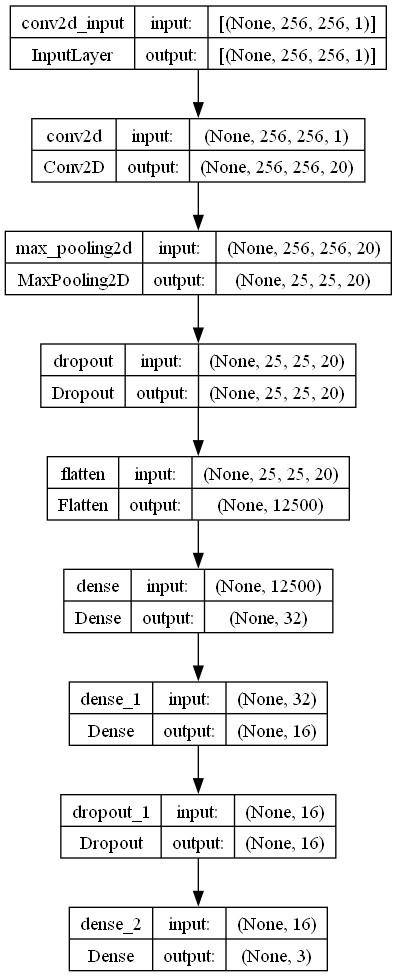

In [12]:
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=20,kernel_size=(5,5),padding='same',input_shape=(256,256,1),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(10,10)))
model_CNN.add(Dropout(0.7))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(units=3, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_CNN.summary()
plot_model(model_CNN,to_file='model.png',show_shapes=True)

In [14]:
reset_keras()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,mode='min')

601


In [15]:
reset_keras()
np.random.seed(1)
train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=64,verbose=1,callbacks=early_stop)

114
Epoch 1/30
171/171 [==============================] - 9s 32ms/step - loss: 0.8681 - accuracy: 0.5595 - val_loss: 0.4267 - val_accuracy: 0.8807
Epoch 2/30
171/171 [==============================] - 5s 29ms/step - loss: 0.4412 - accuracy: 0.8336 - val_loss: 0.2823 - val_accuracy: 0.9029
Epoch 3/30
171/171 [==============================] - 5s 29ms/step - loss: 0.3242 - accuracy: 0.8835 - val_loss: 0.2081 - val_accuracy: 0.9243
Epoch 4/30
171/171 [==============================] - 5s 27ms/step - loss: 0.2791 - accuracy: 0.8979 - val_loss: 0.1926 - val_accuracy: 0.9350
Epoch 5/30
171/171 [==============================] - 5s 27ms/step - loss: 0.2488 - accuracy: 0.9131 - val_loss: 0.1652 - val_accuracy: 0.9473
Epoch 6/30
171/171 [==============================] - 5s 27ms/step - loss: 0.2313 - accuracy: 0.9166 - val_loss: 0.1605 - val_accuracy: 0.9407
Epoch 7/30
171/171 [==============================] - 5s 27ms/step - loss: 0.2121 - accuracy: 0.9233 - val_loss: 0.1768 - val_accuracy: 0.

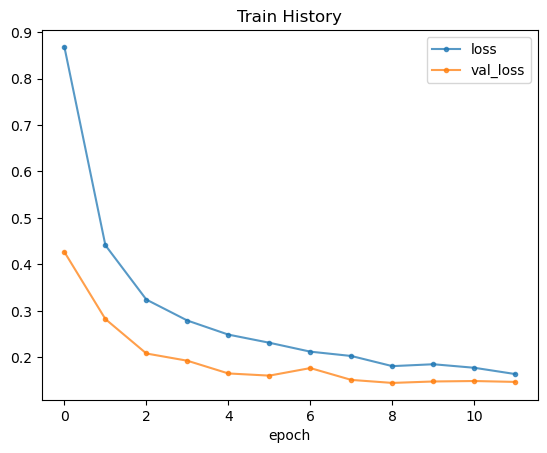

In [16]:
plt.title("Train History")
plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
plt.xlabel("epoch")
plt.legend(["loss","val_loss"])
plt.show()

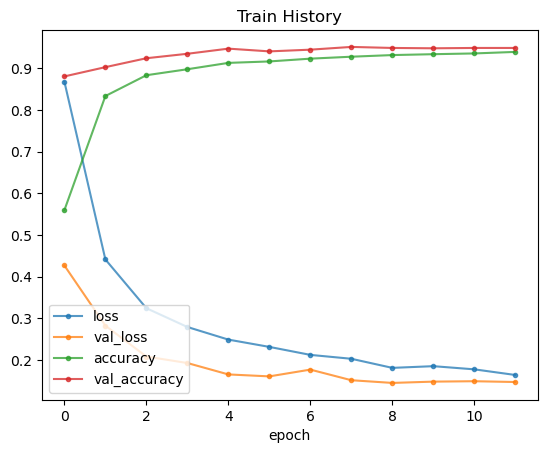

In [17]:
plt.title("Train History")
plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
plt.plot(train_history.history['accuracy'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_accuracy'],marker='.',alpha=0.75)
plt.xlabel("epoch")
plt.legend(["loss","val_loss","accuracy","val_accuracy"], loc='lower left')
plt.show()

In [18]:
reset_keras()
pre=model_CNN.predict(test_feature)

9694
43/43 [==============================] - 0s 6ms/step


In [19]:
score=model_CNN.evaluate(test_feature,test_label)
print(score)

43/43 [==============================] - 0s 6ms/step - loss: 0.1274 - accuracy: 0.9519
[0.1273532509803772, 0.9518518447875977]


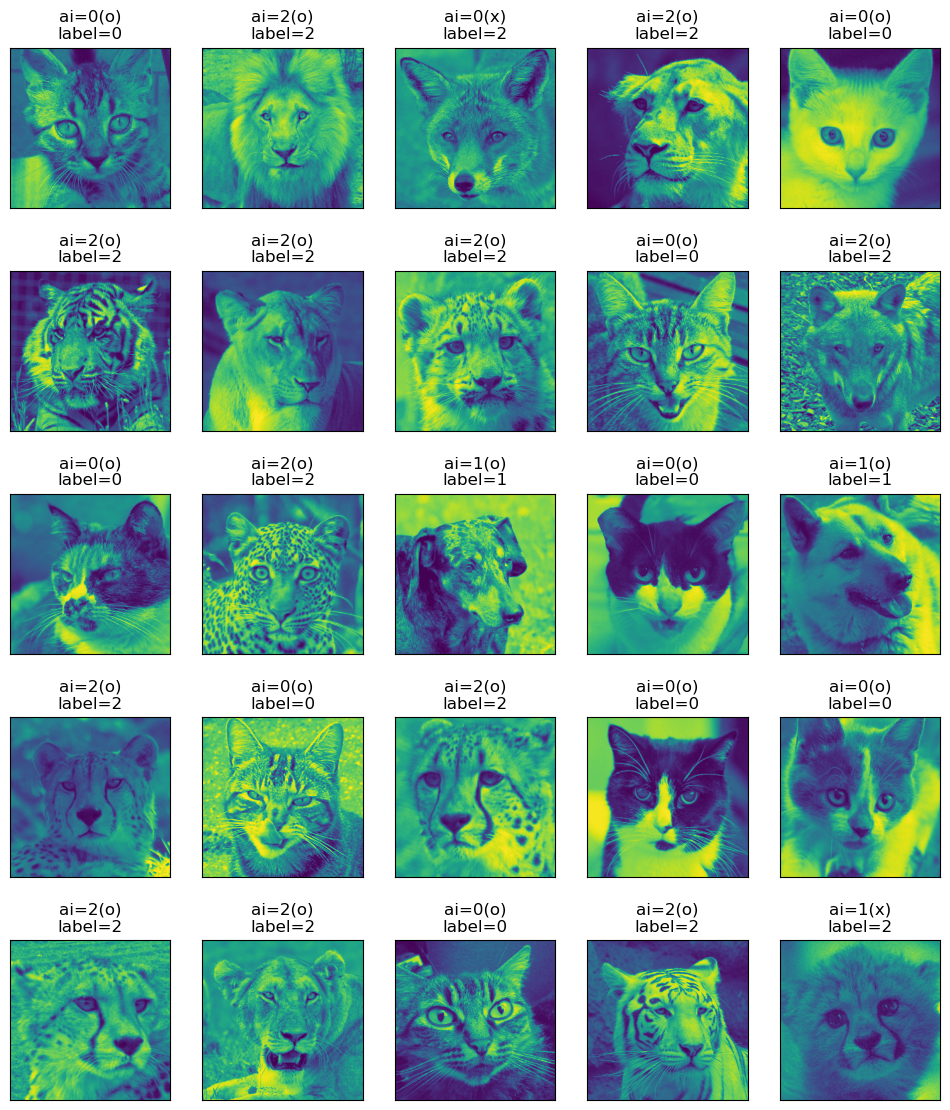

In [20]:
show_images_labels_predictions(test_feature,np.argmax(test_label,axis=1),np.argmax(pre,axis=1),25,50)

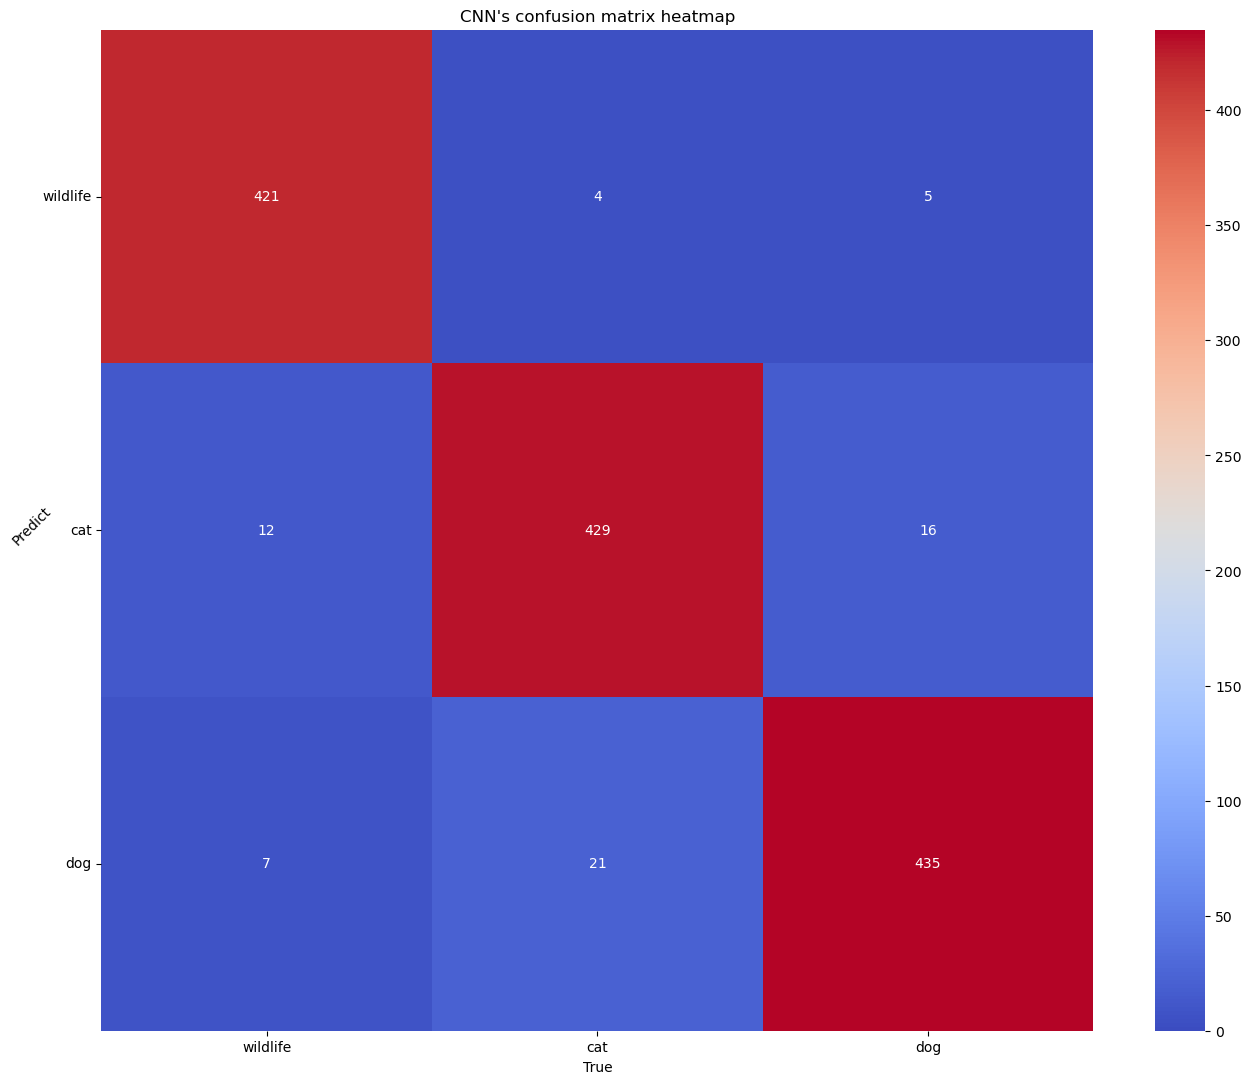

In [21]:
heatmap_label={"cat","dog","wildlife"}
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(pre,axis=1),np.argmax(test_label,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,cmap="coolwarm",annot=True,annot_kws={"size": 10, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("Predict",rotation=45)
heatmap.set_xticklabels(heatmap_label)
plt.xlabel("True")
heatmap.set_yticklabels(heatmap_label, rotation=0)
plt.title("CNN's confusion matrix heatmap")
plt.show()

<h1>驗證集載入與驗證

In [22]:
val_cat_files=glob.glob("./val/cat/*.jpg")
val_dog_files=glob.glob("./val/dog/*.jpg")
val_wildlife_files=glob.glob("./val/wild/*.jpg")

In [23]:
print(len(val_cat_files),len(val_dog_files),len(val_wildlife_files))

500 500 500


In [25]:
val_cat=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in val_cat_files]
val_dog=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in val_dog_files]
val_wildlife=[cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(256,256)) for i in val_wildlife_files]
#,cv2.IMREAD_GRAYSCALE

In [26]:
val_cat=np.array(val_cat)
val_dog=np.array(val_dog)
val_wildlife=np.array(val_wildlife)
print(val_cat.shape,val_dog.shape,val_wildlife.shape)

(500, 256, 256) (500, 256, 256) (500, 256, 256)


In [27]:
label=[]
# 貓的標籤為0
for i in val_cat:
    label.append(0)
# 狗的標籤為1
for i in val_dog:
    label.append(1)
# 野生動物標籤為2
for i in val_wildlife:
    label.append(2)

val_label=np.array(label)
val_feature=np.concatenate((val_cat,val_dog,val_wildlife))
print(val_feature.shape,val_label.shape)

(1500, 256, 256) (1500,)


In [28]:
val_feature = (val_feature.astype("float16") / 255)
val_feature.shape

(1500, 256, 256)

In [29]:
val_label=np_utils.to_categorical(label)
val_label.shape

(1500, 3)

In [30]:
reset_keras()
val_pre=model_CNN.predict(val_feature)

49149
47/47 [==============================] - 0s 6ms/step


In [31]:
val_score=model_CNN.evaluate(val_feature,val_label)
print(val_score)

47/47 [==============================] - 0s 6ms/step - loss: 0.1710 - accuracy: 0.9420
[0.1709742397069931, 0.9419999718666077]


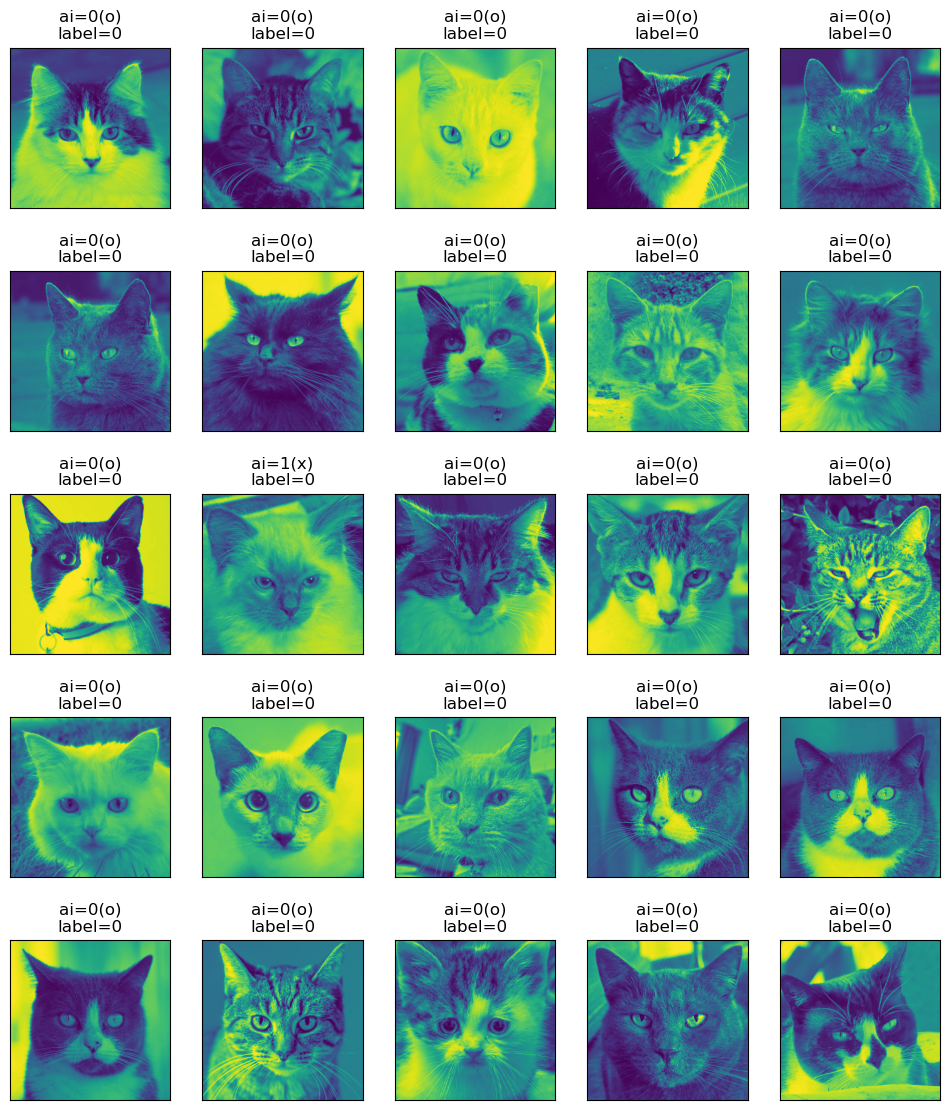

In [32]:
show_images_labels_predictions(val_feature,np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1),0,25)

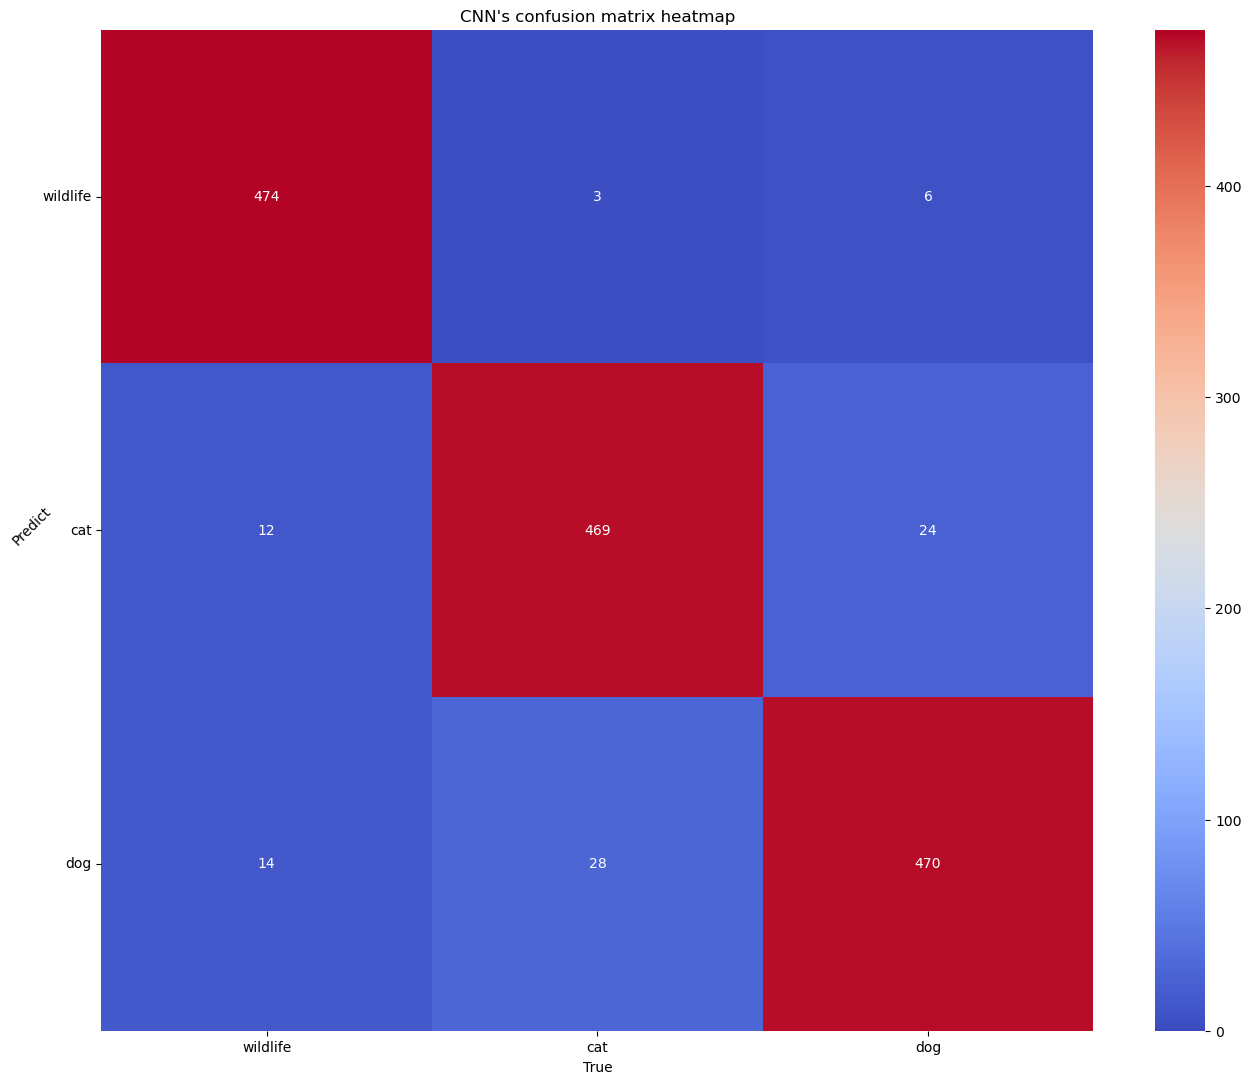

In [33]:
heatmap_label={"cat","dog","wildlife"}
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_pre,axis=1),np.argmax(val_label,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,cmap="coolwarm",annot=True,annot_kws={"size": 10, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("Predict",rotation=45)
heatmap.set_xticklabels(heatmap_label)
plt.xlabel("True")
heatmap.set_yticklabels(heatmap_label, rotation=0)
plt.title("CNN's confusion matrix heatmap")
plt.show()

<h1>Cross Validation

39487
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 20)      520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 20)        0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 dense (Dense)               (None, 32)                400032    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                  

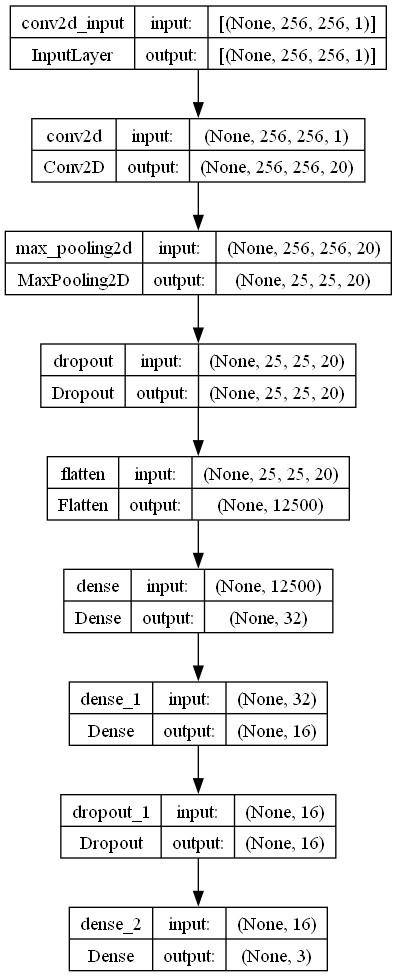

In [152]:
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=20,kernel_size=(5,5),padding='same',input_shape=(256,256,1),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(10,10)))
model_CNN.add(Dropout(0.7))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(units=3, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_CNN.summary()
plot_model(model_CNN,to_file='model.png',show_shapes=True)

In [154]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [155]:
i=1
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
np.random.seed(42)
for x in range(5):
    for (cv_train,cv_val) in kf.split(train_feature): #每次迭代會傳回訓練,測試的索引
        reset_keras()
        cv_train_feature=train_feature[cv_train]
        cv_val_feature = train_feature[cv_val]
        cv_train_label = train_label[cv_train]
        cv_val_label = train_label[cv_val]
        print("取第%d折時"%i,"在訓練集上的準確率:")
        A=model_CNN.fit(cv_train_feature,cv_train_label,epochs=1,batch_size=128,verbose=1)
        train_loss.append(A.history['loss'])
        train_accuracy.append(A.history['accuracy'])
        print("在驗證集上的準確率")
        B=model_CNN.evaluate(cv_val_feature,cv_val_label)
        val_loss.append(B[0])
        val_accuracy.append(B[1])
        i+=1
        print("----------------------------------------------------------------")
    i=1
    print("已完成%d次交叉驗證訓練"%(x+1))
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

3565
取第1折時 在訓練集上的準確率:
76/76 [==============================] - 4s 51ms/step - loss: 0.9635 - accuracy: 0.5309
在驗證集上的準確率
76/76 [==============================] - 1s 6ms/step - loss: 0.6126 - accuracy: 0.8049
----------------------------------------------------------------
3087
取第2折時 在訓練集上的準確率:
76/76 [==============================] - 4s 54ms/step - loss: 0.5457 - accuracy: 0.7970
在驗證集上的準確率
76/76 [==============================] - 1s 6ms/step - loss: 0.3616 - accuracy: 0.8811
----------------------------------------------------------------
1592
取第3折時 在訓練集上的準確率:
76/76 [==============================] - 4s 53ms/step - loss: 0.3709 - accuracy: 0.8645
在驗證集上的準確率
76/76 [==============================] - 1s 7ms/step - loss: 0.2810 - accuracy: 0.8918
----------------------------------------------------------------
1592
取第4折時 在訓練集上的準確率:
76/76 [==============================] - 4s 52ms/step - loss: 0.3049 - accuracy: 0.8868
在驗證集上的準確率
76/76 [==============================] - 1s 7ms/step - loss: 0.2

In [162]:
val_loss=np.array(val_loss)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


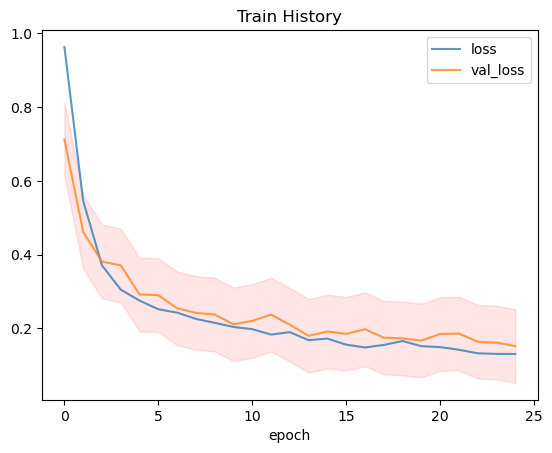

In [163]:
epoch=[i for i in range(25)]
print(epoch)
plt.title("Train History")
plt.plot(train_loss,alpha=0.75)
plt.plot(val_loss,alpha=0.75)
plt.fill_between(epoch,val_loss+0.1,val_loss-0.1, alpha=0.1,color="r")
#plt.fill_between(train_sizes, val_scores_mean - val_scores_std,val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.xlabel("epoch")
plt.legend(["loss","val_loss"])
plt.show()

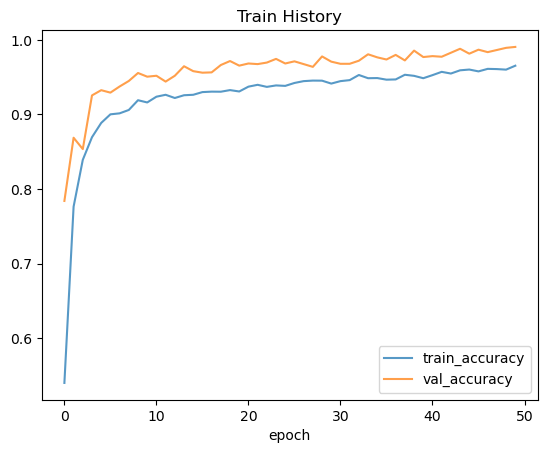

In [127]:
plt.title("Train History")
plt.plot(train_accuracy,alpha=0.75)
plt.plot(val_accuracy,alpha=0.75)
plt.xlabel("epoch")
plt.legend(["train_accuracy","val_accuracy"])
plt.show()

<h1>RF

In [ ]:
feature=np.reshape(feature,(len(feature),256*256))
feature.shape

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=1,random_state=42)

In [45]:
rf_model.fit(train_feature,train_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [46]:
rf_pre=rf_model.predict(test_feature)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [47]:
rf_accuracy=rf_model.score(test_feature,test_label)
print(rf_accuracy)

0.7962962962962963


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [49]:
def plot_digit(data):
    image=data.reshape(256,256)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis('off')

[Text(1, 0.0, 'Not important'),
 Text(1, 0.0012352869846179238, 'Very important')]

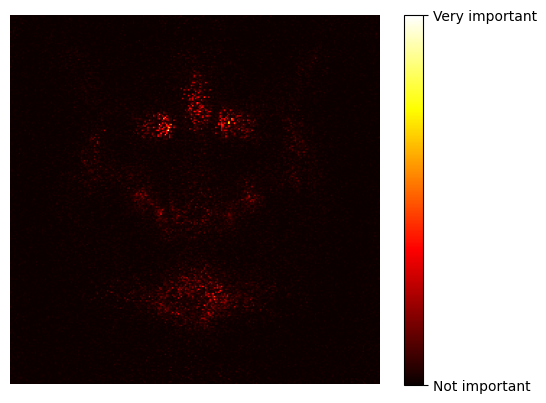

In [50]:
import matplotlib
plot_digit(rf_model.feature_importances_)
char=plt.colorbar(ticks=[rf_model.feature_importances_.min(),rf_model.feature_importances_.max()])
char.ax.set_yticklabels(['Not important','Very important'])

In [51]:
print(rf_pre)

[1 2 0 ... 0 1 1]


<h1>XGB

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas

In [53]:
eval_data=[(test_feature,test_label)]

In [54]:
np.random.seed(1)
XGBC=XGBClassifier(n_estimators=100,learning_rate=0.1,eval_metric="mlogloss",n_jobs=-1,random_state=42,device = "cuda",early_stopping_rounds=10,objective="multi:softmax")

In [55]:
XGBC.fit(train_feature,train_label,eval_set=eval_data,verbose=2)

[0]	validation_0-mlogloss:1.05579
[2]	validation_0-mlogloss:0.98377
[4]	validation_0-mlogloss:0.92449
[6]	validation_0-mlogloss:0.87508
[8]	validation_0-mlogloss:0.83150
[10]	validation_0-mlogloss:0.79759
[12]	validation_0-mlogloss:0.76692
[14]	validation_0-mlogloss:0.73970
[16]	validation_0-mlogloss:0.71593
[18]	validation_0-mlogloss:0.69480
[20]	validation_0-mlogloss:0.67519
[22]	validation_0-mlogloss:0.65633
[24]	validation_0-mlogloss:0.63931
[26]	validation_0-mlogloss:0.62491
[28]	validation_0-mlogloss:0.61093
[30]	validation_0-mlogloss:0.59894
[32]	validation_0-mlogloss:0.58697
[34]	validation_0-mlogloss:0.57535
[36]	validation_0-mlogloss:0.56538
[38]	validation_0-mlogloss:0.55592
[40]	validation_0-mlogloss:0.54651
[42]	validation_0-mlogloss:0.53873
[44]	validation_0-mlogloss:0.53075
[46]	validation_0-mlogloss:0.52443
[48]	validation_0-mlogloss:0.51609
[50]	validation_0-mlogloss:0.50993
[52]	validation_0-mlogloss:0.50307
[54]	validation_0-mlogloss:0.49634
[56]	validation_0-mloglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softmax', ...)

In [57]:
XGBC_pre=XGBC.predict(test_feature)
accuracy=accuracy_score(test_label,XGBC_pre)
print("準確率: %.2f%%"%(accuracy*100))

準確率: 86.22%


[Text(1, 0.0, 'Not important'),
 Text(1, 0.005325749516487122, 'Very important')]

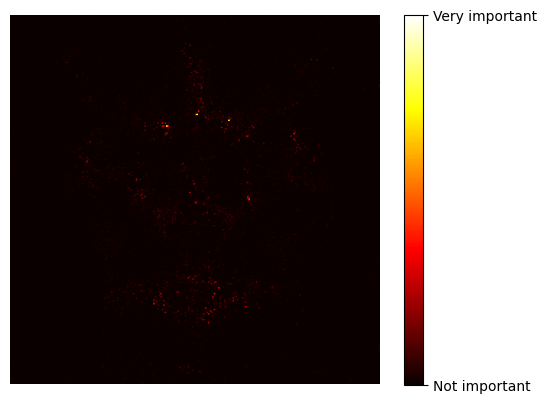

In [58]:
import matplotlib
plot_digit(XGBC.feature_importances_)
char=plt.colorbar(ticks=[XGBC.feature_importances_.min(),XGBC.feature_importances_.max()])
char.ax.set_yticklabels(['Not important','Very important'])